In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
from glob import glob
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

os.chdir(os.path.dirname("../src/"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
from albumentations.pytorch import ToTensor

In [5]:
from siim_pneumothorax.utils import parse_dicom
from siim_pneumothorax.utils import ConfigObject
from siim_pneumothorax.dataset import get_pneumo_loaders
from siim_pneumothorax.losses import Dice_metric
from siim_pneumothorax.losses import IoU_metric
from siim_pneumothorax.losses import MixedLoss
from siim_pneumothorax.losses import MixedFocalLoss
from siim_pneumothorax.losses import DiceLoss
from siim_pneumothorax.losses import FocalLoss
from siim_pneumothorax.models import VanillaUNet

In [6]:
import segmentation_models_pytorch as smp

# Configuration

In [7]:
params = {
    # Loader parameters
    'loader_params': {
        'img_size': 256,
        'batch_size': 8,
        'shuffle': True,
        'num_workers': 8,
        'rgb_channel': False,
        'grid_size': 16
    },
    
    # Loss/metric parameters
    'alpha': 10,
    'gamma': 2,
    'smooth': 1,
    
    # training parameters
    'n_folds': 3,
    'num_epochs': 50,
    'checkpoint_path': '../models/model_checkpoint',
    'model_save_path': '../models/models_comparation/vanilla_unet'
}

# Data preparation

In [8]:
train_fns = sorted(glob('../data/siim/dicom-images-train/*/*/*.dcm'))
test_fns = sorted(glob('../data/siim/dicom-images-test/*/*/*.dcm'))

In [9]:
train_rle_codes = pd.read_csv('../data/siim/train-rle.csv')
train_rle_codes.columns = ["ImageId", "EncodedPixels"]
train_rle_codes['has_pneumothorax'] = (train_rle_codes.EncodedPixels != "-1").astype(int)

In [10]:
train_dataset = pd.DataFrame([parse_dicom(x, train_rle_codes) for x in  train_fns])

In [11]:
test_dataset = pd.DataFrame([parse_dicom(x, is_training=False) for x in  test_fns])

In [12]:
train_dataset.dropna(inplace=True)

In [13]:
# train_dataset = train_dataset.sample(80)

# Model, Loss function, Optimizer and LR Scheduler

In [14]:
def get_parameters(params):
    device = 'cuda'
    model = VanillaUNet()
    model = model.to(device)
    
    # Build optimizer
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    
    # LR scheduler
    lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=params["num_epochs"], eta_min=1e-4
    )

    m_loss = MixedLoss(params['smooth'])
    
    return device, model, optimizer, lr_scheduler, m_loss

# Setup Execution

In [15]:
def train(config, model, train_loader, valid_loader, 
          loss_fn, lr_scheduler, optimizer, device, debug=True):

    history = {
        'loss': [], 'val_loss': [], 'dice': [], 
        'val_dice': [], 'iou': [], 'val_iou': []
    }
    
    dice_metric = Dice_metric()
    iou_metric = IoU_metric()
    
    for epoch in range(config.num_epochs):
        loss, dice, iou = 0.0, [], []

        start_time = time.time()
        model.train()
        
        for idx, (img, mask) in enumerate(train_loader):
            img = img.type(torch.FloatTensor).to(device)
            mask = mask.type(torch.FloatTensor).to(device)
            optimizer.zero_grad()
            recon_batch = model(img)
            loss_batch = loss_fn(recon_batch, mask)
            dice_batch = dice_metric(recon_batch, mask)
            iou_batch = iou_metric(recon_batch, mask)
            
            loss_batch.backward()
            optimizer.step()

            # Compute metrics to all batch
            loss += loss_batch.item()*len(img)
            dice.append(dice_batch.item())
            iou.append(iou_batch.item())

            if debug:
                print("step: {:4d} of {:4d} | loss: {:.4f} | dice: {:.4f} | iou: {:.4f} ".format(idx + 1, len(train_loader),
                    loss_batch.item()*len(img), dice_batch.item(), iou_batch.item()), end='\r')

        loss /= len(train_loader)
        dice = np.nanmean(dice)
        iou = np.nanmean(iou)

        val_loss, val_dice, val_iou, comparison = evaluate(config, model, valid_loader, loss_fn, device)
        lr_scheduler.step()
        elapsed_time = time.time() - start_time
        
        # Display training Metrics
        print('====> Epoch: {:02d} Loss: {:.3f} | val_loss: {:.3f} | val_dice: {:.3f} | val_iou: {:.3f} | Elapsed time: {:.4f}'.format(
          epoch+1, loss, val_loss, val_dice, val_iou, elapsed_time))
        
        # Compute the statistics of the last epoch and save to history
        history['loss'].append(loss)
        history['val_loss'].append(val_loss)
        history['dice'].append(dice)
        history['val_dice'].append(val_dice)
        history['iou'].append(iou)
        history['val_iou'].append(val_iou)

        # Checkpoint the model
        torch.save(model.state_dict(), config.checkpoint_path)
        
    return history

In [16]:
def evaluate(config, model, heldout_loader, loss_fn, device):
    model.eval()
    heldout_loss = 0
    heldout_dice = []
    heldout_iou = []
    
    dice_metric = Dice_metric()
    iou_metric = IoU_metric()

    with torch.no_grad():
        for i, (img, mask) in enumerate(heldout_loader):
            img = img.type(torch.FloatTensor).to(device)
            mask = mask.type(torch.FloatTensor).to(device)
            recon_batch = model(img)
            heldout_loss += loss_fn(recon_batch, mask).item()*len(img)
            heldout_dice.append(dice_metric(recon_batch, mask).item())
            heldout_iou.append(iou_metric(recon_batch, mask).item())

    heldout_loss /= len(heldout_loader)
    heldout_dice = np.nanmean(heldout_dice)
    heldout_iou = np.nanmean(heldout_iou)
    
    n = min(img.size(0), 16)
    comparison = [img[:n], recon_batch[:n], mask[:n]]
    
    return heldout_loss, heldout_dice, heldout_iou, comparison

In [17]:
def KFoldTrainer(dataset, params):
    metrics = []
    skf = StratifiedKFold(n_splits=params['n_folds'])

    # Start kFold
    for fold, (train_index, val_index) in enumerate(skf.split(dataset, dataset['has_pneumothorax'])):
        print("======= Fold {}/{} =======".format(fold+1, params['n_folds']))
        train_dataset, val_dataset = dataset.iloc[train_index], dataset.iloc[val_index]
        
        # Balance the dataset
        g = train_dataset.groupby('has_pneumothorax')
        train_dataset = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
        
        # Configure parameters
        config = {
            'smooth': params["smooth"],
            'num_epochs': params['num_epochs'],
            'checkpoint_path': '{}.pt'.format(params['checkpoint_path']),
            'model_save_path': '{}_fold_{}.pt'.format(params['model_save_path'], fold)
        }

        # Create data loaders
        train_loader = get_pneumo_loaders(df=train_dataset, is_train=True, **params['loader_params'])
        val_loader = get_pneumo_loaders(df=val_dataset, is_train=False, **params['loader_params'])

        # Start training
        config = ConfigObject(**config)
        device, model, optimizer, lr_scheduler, m_loss = get_parameters(params)
        history = train(
            config, model, train_loader, val_loader, 
            m_loss, lr_scheduler, optimizer, device, debug=True
        )

        metrics.append(history)
        torch.save(model.state_dict(), config.model_save_path)
        print("") # Break line
        break

    return metrics

# Train

In [18]:
 history = KFoldTrainer(train_dataset, params)

======= Fold 1/3 =======
====> Epoch: 01 Loss: 8.977 | val_loss: 8.265 | val_dice: 0.007 | val_iou: 0.778 | Elapsed time: 276.8062
====> Epoch: 02 Loss: 8.227 | val_loss: 8.144 | val_dice: 0.020 | val_iou: 0.778 | Elapsed time: 283.9232
====> Epoch: 03 Loss: 8.032 | val_loss: 7.940 | val_dice: 0.054 | val_iou: 0.778 | Elapsed time: 284.7600
====> Epoch: 04 Loss: 7.732 | val_loss: 7.788 | val_dice: 0.072 | val_iou: 0.778 | Elapsed time: 286.4024
====> Epoch: 05 Loss: 7.682 | val_loss: 7.626 | val_dice: 0.075 | val_iou: 0.778 | Elapsed time: 288.3192
====> Epoch: 06 Loss: 7.673 | val_loss: 7.654 | val_dice: 0.078 | val_iou: 0.778 | Elapsed time: 293.7861
====> Epoch: 07 Loss: 7.568 | val_loss: 7.693 | val_dice: 0.082 | val_iou: 0.778 | Elapsed time: 292.8413
====> Epoch: 08 Loss: 7.543 | val_loss: 7.703 | val_dice: 0.087 | val_iou: 0.778 | Elapsed time: 297.3431
====> Epoch: 09 Loss: 7.501 | val_loss: 7.461 | val_dice: 0.101 | val_iou: 0.778 | Elapsed time: 292.2526
====> Epoch: 10 Loss:

# Performance Report

In [19]:
print("Loss = mean: {:.3f} | std: {:.3f}".format(
    np.mean([d['val_loss'][-1] for d in history]),
    np.std([d['val_loss'][-1] for d in history])
))

Loss = mean: 6.364 | std: 0.000


In [20]:
print("Dice = mean: {:.3f} | std: {:.3f}".format(
    np.mean([d['val_dice'][-1] for d in history]),
    np.std([d['val_dice'][-1] for d in history])
))

Dice = mean: 0.227 | std: 0.000


In [21]:
print("IoU = mean: {:.3f} | std: {:.3f}".format(
    np.mean([d['val_iou'][-1] for d in history]), 
    np.std([d['val_iou'][-1] for d in history])
))

IoU = mean: 0.778 | std: 0.000


# Visualization

In [22]:
ids_val_fold0 = [
    'c7b2d2e9-4f5c-4580-8424-8d3d726e453c', '47ff3888-bf35-42cc-a29e-9d6488359f94', 
    '4e806d37-522c-47cb-95ff-21488a426104', 'fead8485-9e28-4617-8d10-a9a190da5014', 
    'e225e446-ca02-4b3b-a495-cf61c2687322', '48574d65-277c-49b4-92b2-6f990e79caf0', 
    'c01395ea-88ea-467e-88bb-94c47569394d', '277da72c-8efa-40c8-92fb-0b2884b44355', 
    'bb54f8a7-5c2e-43bc-8873-0d657e415946', '0ee8e9d7-50ab-46d7-8db8-152c13f41095', 
    '402dfd35-ed62-4c02-bf5b-d8cc46a0e8ee', '0ef44f50-5791-43a7-9896-68fbd3d18e9c', 
    '7b922525-daf7-4674-bfa5-2513e55d2a29', '6d6dccd6-f8c0-45b7-bc16-b9795d042655', 
    '5e46587f-4f67-4e2a-8808-6c9fdaa6dea5', 'fa1439dd-7166-40a5-8281-54b5df9174ea', 
    '53729b1b-5b2a-41a1-9ef7-e7a4a4aa7223', 'e358ff00-d6bb-4ca2-a48a-22bb277e099a', 
    '7c66788f-5e7e-443f-935c-7b7ce00a6c66', '6f801b77-06ce-468a-8e48-1ffeec5ff815', 
    '5c92550b-2c25-4447-ae41-b155e10c1496', '6376624f-5e0a-47a7-b4da-33dca76dec6c', 
    'f0f2f5c5-92e3-4267-9103-037f0d2bd181', 'd7b92892-9405-4daf-a706-a48a8487e5ce', 
    '050e62b3-fb33-4f6a-8c6b-d530c5d554d8', '4001bdbc-9ca5-4607-a7a6-d8fa3f195302', 
    '3bac13d7-222e-4a52-8726-2eb70f8462df', '9234eeba-d448-4268-be36-ee66fba78df8', 
    '6780ceaf-71d6-44e0-9b09-d8f821e99e08', '8196ac82-82e8-43c0-abf4-0308f10f13d6', 
    'c3041102-06e3-48f3-b8f8-1dab16142cbf', 'c09576d7-f0a9-451f-ba0c-23c90fe35e10', 
    '3a5c46be-fab6-4585-88ed-c682e376ee37', 'f210ecc8-480e-4879-9e2e-dbf1f3d309c4', 
    '3ce84286-0a8f-4375-9b23-a1f0a62c4a8e', 'ffd3357a-c2eb-4826-a0c5-abccf0df3fe9', 
    '762bd83d-bc5e-4771-b040-55a93b3435ea', 'eff090dc-6546-4316-ba2a-6c9a5a90764f', 
    '5c3fe83b-c226-4447-90ee-163f693e24a8', '4c012ba8-5a80-47e9-b9c1-cf8cfbf50965', 
    '07aa3487-c94f-41e3-8947-effb38e6d64d', '84c2c644-c1fe-47f0-9a8d-900ef87167b9', 
    '410399d5-2c27-4831-9b2b-c85322eded0c', 'e999be1b-1652-4a2e-adc3-1916a3825505', 
    'b2019056-3fea-4b8c-8be4-eb91e27e8031', '3296c233-d14d-4467-b6d8-70090aaf19b7', 
    '2869fa02-1760-4321-b9e2-68e2421bccb6', '2f366d03-c271-44a2-8a74-2ddfed8b055b', 
    '8fb58c04-1e74-4ca8-99b0-2796f75168d4', '67c9e90f-634f-402f-a2bb-7bfa0fdf2f41', 
    '882d3757-813e-4a33-9e40-09daeb2690da', 'c1499ea8-9b0e-410b-a1a5-a8e8caf25a7d', 
    'dfb06563-1c03-48b7-9b97-ba2c90543f5a', '83e9c9a5-e3e2-466c-b52c-147a8e1ba389', 
    'c3bdf5da-a67e-4db1-b7e8-1df793c7e6b5', 'b92fdd8f-c62a-4302-917b-7cecbcc39ad6', 
    '24254c26-b2cc-4819-b751-0831f643c8d8', '74f2f120-5457-484c-b4cf-d3752d3a898f', 
    '17cd523f-8587-4ef7-a43e-6de53dfc2424', 'dcb6f096-5c18-4053-833a-ee3d7460d9ab', 
    'dd4a4731-3ede-4f5c-a2dc-296bccd82ce9', '9e37e115-7deb-4156-82ee-31f7cde63d45', 
    'a0b139e4-ff20-485b-b31b-bb3c8bec1c5b', 'f496f0f2-3376-44d5-82e9-bfbe4276d8e2'
]

In [23]:
temp = train_dataset[train_dataset.user_id.isin(ids_val_fold0) & (train_dataset.has_pneumothorax == 1)]

In [24]:
model_resnet = smp.Unet('resnet34', encoder_weights='imagenet', in_channels=1)
model_resnet.load_state_dict(torch.load('../models/models_comparation/resnet34_unet_dice_0358.pt'))
model_resnet = model_resnet.to('cuda')

In [25]:
model_vanilla = VanillaUNet()
model_vanilla.load_state_dict(torch.load('../models/models_comparation/vanilla_unet_fold_0_dice0227.pt'))
model_vanilla = model_vanilla.to('cuda')

In [26]:
train_loader = get_pneumo_loaders(df=temp, is_train=False, **params['loader_params'])

In [28]:
with torch.no_grad():
    for img, mask in train_loader:
        img = img.to('cuda')
        predicted_mask = model_vanilla(img)
        predicted_mask_2 = model_resnet(img)
        break

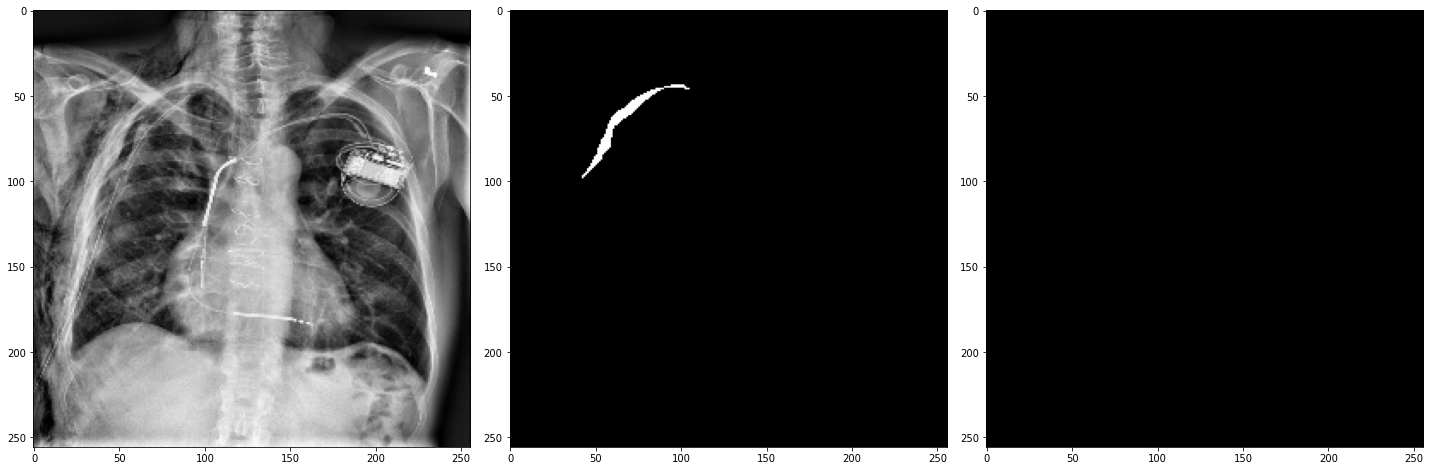

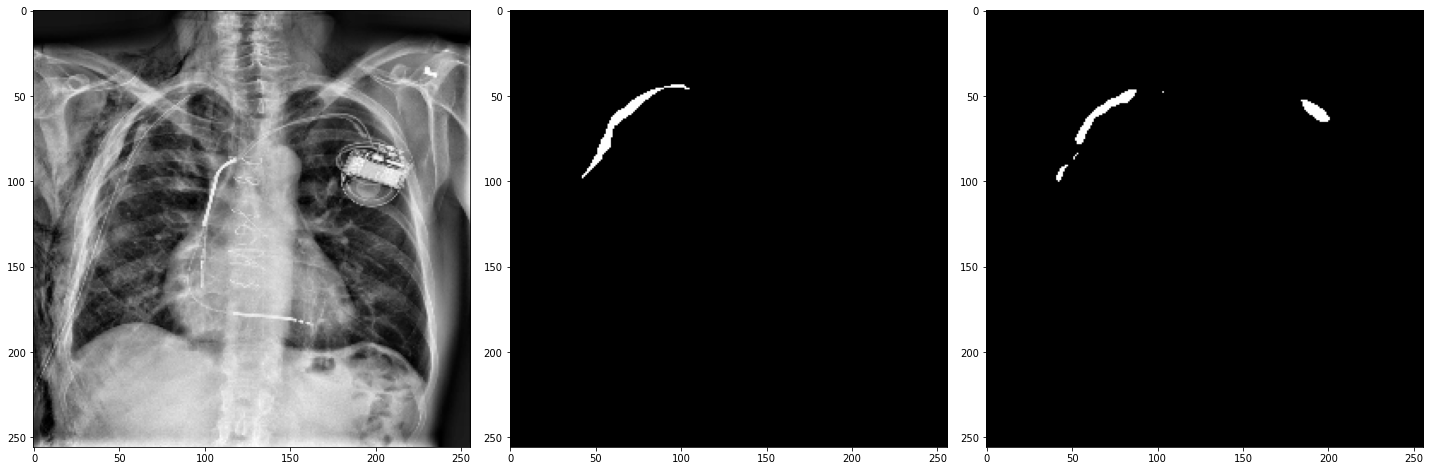

In [30]:
# 0, 2, 4, 3, 6, 7
idx = 0

p_mask = (nn.Sigmoid()(predicted_mask[idx][0, :, :]).cpu() > .5).int()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
axes[0].imshow(img[idx, 0, :, :].cpu(), cmap='gray')
axes[1].imshow(mask[idx, 0, :, :], cmap='gray')
axes[2].imshow(p_mask, cmap='gray')
plt.tight_layout()

p_mask = (nn.Sigmoid()(predicted_mask_2[idx][0, :, :]).cpu() > .5).int()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
axes[0].imshow(img[idx, 0, :, :].cpu(), cmap='gray')
axes[1].imshow(mask[idx, 0, :, :], cmap='gray')
axes[2].imshow(p_mask, cmap='gray')
plt.tight_layout()